In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model


from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

Using TensorFlow backend.


In [2]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [3]:
batch_size = 256
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 2
num_classes = 10
dropout_rate = 0.3

In [4]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]


train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)

In [5]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),   name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim),  name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

In [6]:
with tf.variable_scope('generator'):
    x = concatenate([z, lbl])
    x = Dense(7*7*64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
generator = Model([z, lbl], generated, name='generator')

In [7]:
def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])


with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    
    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], d, name='Discriminator')

In [8]:

generated_z = generator([z, lbl])

discr_img   = discrim([img, lbl])
discr_gen_z = discrim([generated_z, lbl])

gan_model = Model([z, lbl], discr_gen_z, name='GAN')
gan   = gan_model([z, lbl])

In [9]:
log_dis_img   = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5*(log_dis_gen_z + log_dis_img)

In [10]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
discrim_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)


In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
# Шаг обучения генератора
def step(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_gen], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

# Шаг обучения дискриминатора
def step_d(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

In [13]:

# Массивы, в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры, берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((28 * n, 28 * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_generated = sess.run(generated_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_generated[0].squeeze()
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


n_compare = 10
def on_n_period(period):
    clear_output() # Не захламляем output

    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    periods.append(period)

8


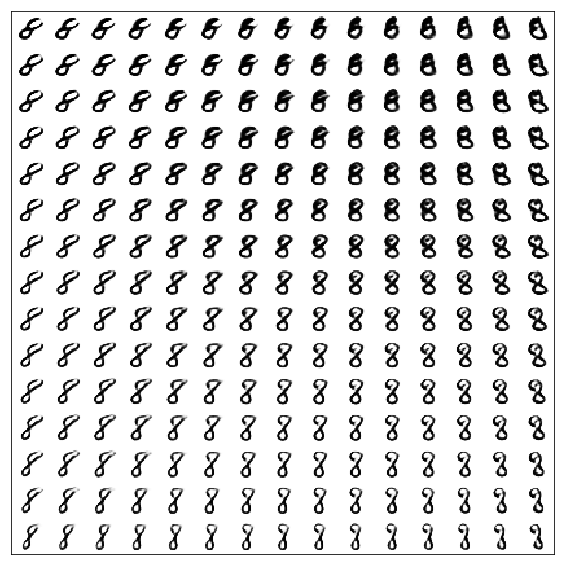

0.6736499
....................0.6772557
....................0.6872206
....................0.6900364
....................0.68010736
....................0.6742193
....................0.6755177
....................0.67678285
....................0.67627966
..................

KeyboardInterrupt: 

In [14]:
batches_per_period = 20 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле

for i in range(5000):
    print('.', end='')
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = np.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

    # Шаги обучения генератора
    for j in range(k_step):
        l_d = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическое рисование результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(l_d)

In [15]:
i

3778

In [16]:
import pickle

In [22]:
periods

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180]

In [ ]:
pickle.dump(period)